In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score
import os 
import mglearn
import re
import datetime
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.cluster import KMeans

In [2]:

## prepare_weather_data 

WEATHER_DIR = './weather'
all_files = os.listdir(WEATHER_DIR)

data = pd.DataFrame()

for weather_file in all_files :

    if str(weather_file[-4:]) == '.csv' :

        file_path = os.path.join(WEATHER_DIR,str(weather_file))
        wdata = pd.read_csv(str(file_path),skiprows=range(16))
        data = data.append(wdata)



In [3]:
## remove feature with Nan and create timestamps for each sample

c = [i for i in data.columns if data.loc[:,i].count() != 0  and i!= 'Hmdx']
ndata = data[c]

def to_datetime(row) : 
    REGEX = '^([0-9]{4})-([0-9]{2})-([0-9]{2}) ([0-9]{2}).*$'
    m = re.match(REGEX,row)
    
    year = int(m.group(1))
    month = int(m.group(2))
    day = int(m.group(3))
    time =  int(m.group(4))
    
    return datetime.datetime(year,month,day,time,0,0)

ndata['Date/Time'] = ndata['Date/Time'].apply(to_datetime)
ndata['timestamp'] = ndata['Date/Time'].values.astype(np.int64)
ndata.head()

,Date/Time,Year,Month,Day,Time,Data Quality,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Wind Chill,Weather,timestamp
0,2016-05-01 00:00:00,2016,5,1,00:00,‡,9.8,7.6,86.0,34.0,7.0,32.2,102.53,NaN,NaN,1462060800000000000
1,2016-05-01 01:00:00,2016,5,1,01:00,‡,10.1,7.0,81.0,35.0,5.0,24.1,102.49,NaN,Clear,1462064400000000000
2,2016-05-01 02:00:00,2016,5,1,02:00,‡,9.5,6.2,80.0,36.0,1.0,24.1,102.46,NaN,NaN,1462068000000000000
3,2016-05-01 03:00:00,2016,5,1,03:00,‡,9.2,6.7,84.0,11.0,8.0,24.1,102.43,NaN,NaN,1462071600000000000
4,2016-05-01 04:00:00,2016,5,1,04:00,‡,8.5,6.0,84.0,2.0,7.0,32.2,102.41,NaN,Clear,1462075200000000000


(40,)

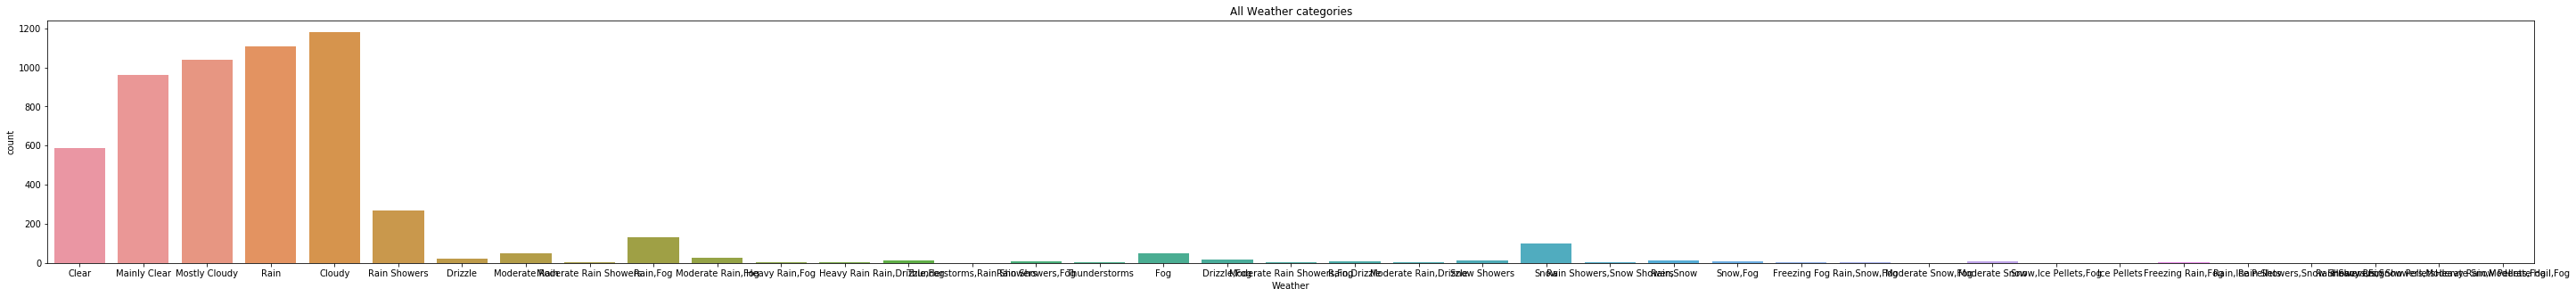

In [40]:
## shows unique weather category descritipion


weather_desc = pd.DataFrame(np.array(ndata['Weather'].unique()),columns=['WEATHER_DESC.'])
weather_desc
fig,ax = plt.subplots(figsize=(50,5))
x = sns.countplot(ax=ax,data=data,x=data['Weather']).set_title('All Weather categories')
plt.savefig('plots/weather.jpg')

ndata['Weather'].unique().shape


In [41]:
## FEATURE COMPARISON

def assign_colors(val) : 
    
    
    if val == 'Clear' : 
        color = 'pink'
    elif val == 'Mainly Clear' : 
        color = 'Orange'
    elif val == 'Mostly Cloudy' : 
        color = 'coral'
    elif val == 'Rain' : 
        color = 'Blue'
    elif val == 'Cloudy' : 
        color = 'dimgrey'
    elif val == 'Rain Showers' : 
        color = 'green'
    else : 
        color = 'gold'
    return color

ndata['color'] = ndata['Weather'].apply(assign_colors)
features = ndata[['Data Quality','Temp (°C)','Dew Point Temp (°C)','Rel Hum (%)','Wind Dir (10s deg)','Wind Spd (km/h)','Visibility (km)','Stn Press (kPa)']]


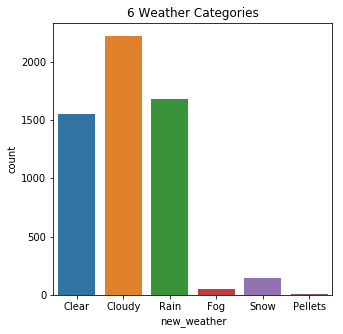

In [49]:
## FEATURE-ENGINEERING : CREATING 8 NEW FIELDS TO IDENTIFY DESCRIPTIONS SIMENTANEOUSLY
## Thunderstorms,drizzle are identified as rain category



def is_rain(val) : 
    REGEX1 = '^.*Rain.*$'
    REGEX2 = '^.*Drizzle.*$'
    REGEX3 = '^.*Thunderstorms.*$'
    if re.match(REGEX1,str(val)) is not None or re.match(REGEX2,str(val)) is not None or re.match(REGEX3,str(val)) is not None   : 
       
        return 1 
    else : 
        return 0
    
def is_clear(val) : 
    if re.match('^.*Clear.*$',str(val) )is not None : 
        return 1 
    else : 
        return 0

def is_snow(val) :
    if re.match('^.*Snow.*$',str(val) )is not None : 
        return 1 
    else : 
        return 0

def is_fog(val) : 
    if re.match('^.*Fog.*$',str(val) )is not None : 
        return 1 
    else : 
        return 0
    
def is_cloudy(val) : 
    if re.match('^.*Cloudy.*$',str(val) )is not None : 
        return 1 
    else : 
        return 0
    
    
def is_pellets(val) : 
    if re.match('^.*Pellets.*$',str(val) ) is not None : 
        return 1 
    else : 
        return 0

def new_weather_label(val) : 
    
    
    if val.is_pellets == 1 : 
        return 'Pellets'
    elif val.is_snow == 1 : 
        return 'Snow'
    elif val.is_clear == 1 : 
        return 'Clear'
    elif val.is_rain == 1 : 
        return 'Rain'
    elif val.is_cloudy == 1 : 
        return 'Cloudy'
    elif val.is_fog == 1 : 
        return 'Fog'
    else : 
        return 'Unknown'
    


ndata['is_clear'] = ndata['Weather'].apply(is_clear)
ndata['is_snow'] = ndata['Weather'].apply(is_snow)
ndata['is_fog'] = ndata['Weather'].apply(is_fog)
ndata['is_cloudy'] = ndata['Weather'].apply(is_cloudy)
ndata['is_pellets'] = ndata['Weather'].apply(is_pellets)

ndata['is_rain'] = ndata['Weather'].apply(is_rain)


ldata = ndata[ndata['Weather'].isnull() == 0]
udata = ndata[ndata['Weather'].isnull() == 1]

ldata['new_weather'] = ldata.apply(new_weather_label,axis=1)
ldata['new_weather'].value_counts()

fig,ax = plt.subplots(figsize=(5,5))
sns.countplot(ax=ax,data=ldata,x=ldata['new_weather']).set_title('6 Weather Categories')
plt.savefig('plots/six_weather_Cat.jpg')

In [7]:
## image data 

def image_datetime(row) :
    year = int(row['year'])
    month = int(row['month'])
    day = int(row['day'])
    hour = int(row['hour'])
 
    return datetime.datetime(year,month,day,hour,0,0)


IMAGE_DIR = 'image_data/katkam-scaled'

contents = os.listdir(IMAGE_DIR)
filenames = pd.DataFrame(contents,columns=['title'])


filenames['year'] = filenames['title'].str.extract('katkam-([0-9]{4}).*\.jpg')
filenames['month'] = filenames['title'].str.extract('katkam-[0-9]{4}([0-9]{2}).*\.jpg')
filenames['day'] = filenames['title'].str.extract('katkam-[0-9]{4}[0-9]{2}([0-9]{2}).*\.jpg')
filenames['hour'] = filenames['title'].str.extract('katkam-[0-9]{4}[0-9]{2}[0-9]{2}([0-9]{2}).*\.jpg')

filenames['timestamp'] = filenames.apply(image_datetime,axis=1)
filenames.head()

,title,year,month,day,hour,timestamp
0,katkam-20160605060000.jpg,2016,06,05,06,2016-06-05 06:00:00
1,katkam-20160605070000.jpg,2016,06,05,07,2016-06-05 07:00:00
2,katkam-20160605080000.jpg,2016,06,05,08,2016-06-05 08:00:00
3,katkam-20160605090000.jpg,2016,06,05,09,2016-06-05 09:00:00
4,katkam-20160605100000.jpg,2016,06,05,10,2016-06-05 10:00:00


In [8]:
## compiling sun_present and average color data

sun_present_file = 'image_data/SUN_PRESENT.csv'
sun_present = pd.read_csv(sun_present_file,header=None)
sun_present.columns =['image_index','sun_present']

average_color_file = 'image_data/KATKAM_labeled_colors2.csv'
average_color = pd.read_csv(average_color_file)
average_color.columns=['file_index','region_id','r','g','b','Label']

sky_color = average_color[average_color['region_id']==1]
sky_color = sky_color[['file_index','r','g','b','Label']]
sky_color = sky_color.reset_index()
sky_color.drop(['index'],axis=1)

filenames['sun_present'] = sun_present['sun_present']
filenames['sky_color_r'] = sky_color['r']
filenames['sky_color_g'] = sky_color['g']
filenames['sky_color_b'] = sky_color['b']
filenames['color_label'] = sky_color['Label']

sun_present['image_index'].count()

average_color.head()

,file_index,region_id,r,g,b,Label
0,3,1,0.52310,0.58318,0.66937,blue
1,3,2,0.40055,0.41255,0.43536,grey
2,3,3,0.12153,0.11097,0.10294,black
3,3,4,0.22364,0.18298,0.16562,black
4,4,1,0.47316,0.59140,0.75207,blue


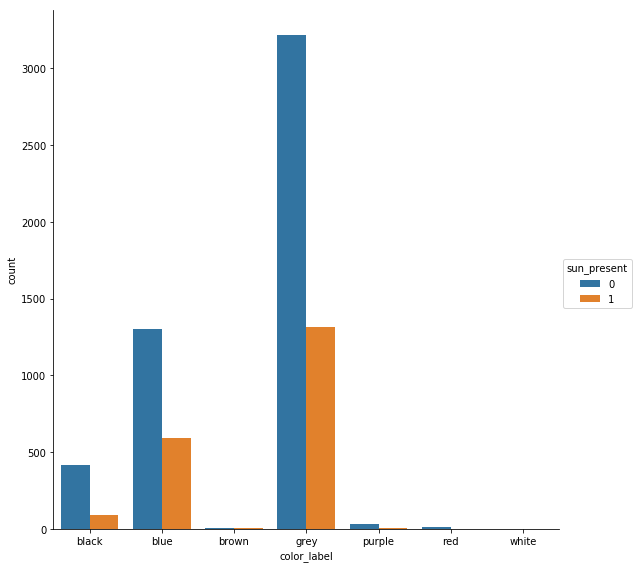

In [9]:
## VISUALIZATIONS FOR THE COLOR <do this >

color_data = filenames[['color_label','sun_present']]
color_data_sun = color_data[color_data['sun_present']==1]
color_data_not_sun = color_data[color_data['sun_present']!=1]


color_agg = color_data.groupby(['color_label','sun_present']).size().to_frame().reset_index()
color_agg.columns=['color_label','sun_present','count']

sns.factorplot(x='color_label',y='count',hue='sun_present',data=color_agg,kind='bar',size=8)

## As we can see, the gray is the highest color when sun was not present. Because the distribution is
## very concentrated in few results, it can affect the training dataset and later predictions.

In [10]:
widata = ldata.merge(filenames,on='timestamp')
widata.columns

Index(['Date/Time', 'Year', 'Month', 'Day', 'Time', 'Data Quality',
       'Temp (°C)', 'Dew Point Temp (°C)', 'Rel Hum (%)', 'Wind Dir (10s deg)',
       'Wind Spd (km/h)', 'Visibility (km)', 'Stn Press (kPa)', 'Wind Chill',
       'Weather', 'timestamp', 'color', 'is_clear', 'is_snow', 'is_fog',
       'is_cloudy', 'is_pellets', 'is_rain', 'new_weather', 'title', 'year',
       'month', 'day', 'hour', 'sun_present', 'sky_color_r', 'sky_color_g',
       'sky_color_b', 'color_label'],
      dtype='object')

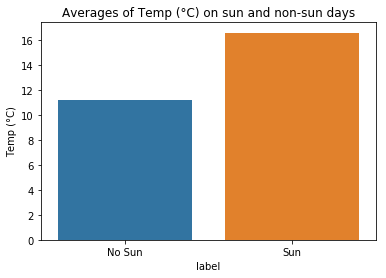

In [53]:
## lets look at average temperature when sun_present vs not sun_present


sun_and_temp = widata[['Temp (°C)','sun_present']]
sun_temp_avg = sun_and_temp.groupby('sun_present').agg(np.mean)
sun_temp_avg = sun_temp_avg.reset_index()
sun_temp_avg['label'] = ['No Sun','Sun'] 

#sns.countplot(x='sun_present',data=sun_and_temp)
sun_temp_avg = sun_temp_avg[['label','Temp (°C)']]
sns.barplot(x='label',y='Temp (°C)',data=sun_temp_avg).set_title('Averages of Temp (°C) on sun and non-sun days')
plt.savefig('plots/tempvssun.jpg')

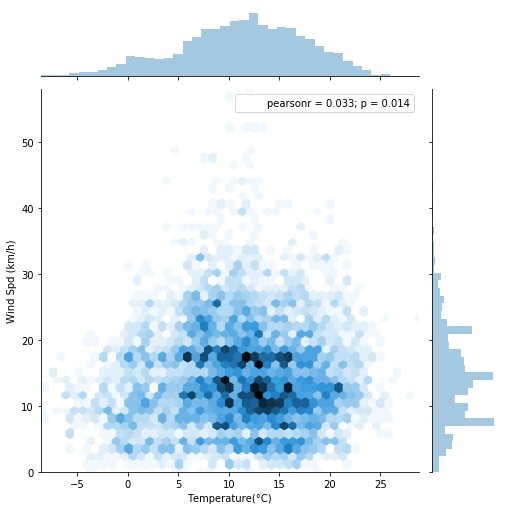

In [12]:
## RELATIONSHIP BETWEEN TEMPERATURE AND WIND DIRECTION

l = ldata[['Temp (°C)','Wind Spd (km/h)']]


ax = sns.jointplot(x=l['Temp (°C)'].values,y=l['Wind Spd (km/h)'].values,kind='hex',size=7)
ax.set_axis_labels('Temperature(°C)','Wind Spd (km/h)')


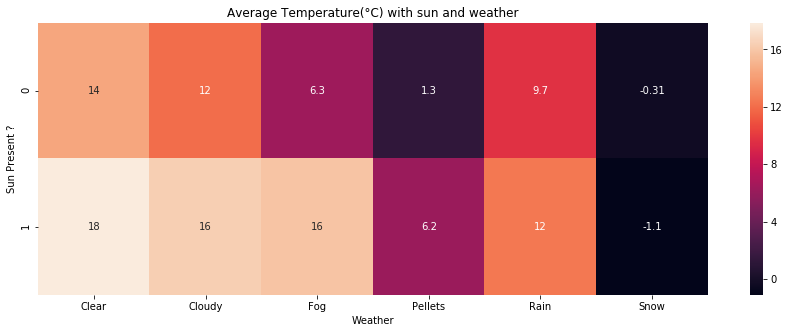

In [54]:
## HEATMAP OF TEMPERTURE, WEATHER AND SUN_PRESENT

ll = widata[['new_weather','sun_present','Temp (°C)']]

ll_pivot = ll.pivot_table(index='sun_present',columns='new_weather',values='Temp (°C)',aggfunc='mean')

hfig,hax = plt.subplots(figsize=(15,5))
sns.heatmap(ll_pivot,annot=True,ax=hax).set_title('Average Temperature(°C) with sun and weather')
plt.xlabel('Weather')
plt.ylabel('Sun Present ?')
plt.savefig('plots/pivot.jpg')

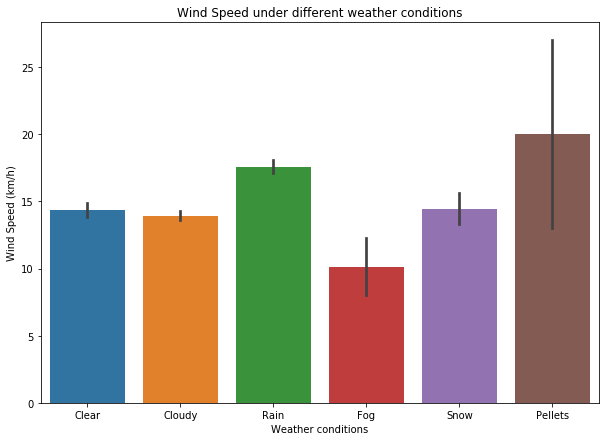

In [52]:
## wind speed and weather conditions

fig,ax = plt.subplots(figsize=(10,7))
sns.barplot(ax=ax,x='new_weather',y='Wind Spd (km/h)',data=widata)
ax.set_xlabel('Weather conditions')
ax.set_ylabel('Wind Speed (km/h)')
ax.set_title('Wind Speed under different weather conditions')
plt.savefig('plots/windvsweather.jpg')

In [15]:
## CRIME DATA

filename = 'crime_csv_all_years.csv'
cdata = pd.read_csv(filename)

years = ['2016','2017']

def year_specific(val) : 
    val = str(val)
    if val in years : 
        return val
    else : 
        return np.nan

to_string = lambda x:str(x)

def crime_datetime(row) : 
    year = int(row['YEAR'])
    month = int(row['MONTH'])
    day = int(row['DAY'])
    hour = int(row['HOUR'])
    return datetime.datetime(year,month,day,hour,0,0)


## only data from 2016 and 2015
cdata['YEAR'] = cdata['YEAR'].apply(to_string)
cdata['YEAR'] = cdata['YEAR'].apply(year_specific)
cdata = cdata.dropna(axis=0,how='any')

## Adding the timestamp
cdata['date/time'] = cdata.apply(crime_datetime,axis=1)
cdata['timestamp'] = cdata['date/time'].values.astype(np.int64)


In [16]:
## WEATHER SNOW DATA 

SNOW_FILE = 'snow.csv'
snow_data = pd.read_csv(SNOW_FILE)
snow_features = ['date','avg_temperature','avg_pressure_station','snow','sunlight','rain','precipitation']
snow_data = snow_data[snow_features]
snow_data['date_only'] = pd.to_datetime(snow_data['date'])

## JOINING SNOW_DATA AND JOINED_DATA
joined_data = widata.merge(cdata,on='timestamp')

def date_only(row) : 
    year = row['Year']
    month = row['Month']
    day = row['Day']
    return datetime.datetime(year,month,day,0,0,0)

joined_data['date_only'] = joined_data.apply(date_only,axis=1)
joined_data = joined_data.merge(snow_data,on='date_only')



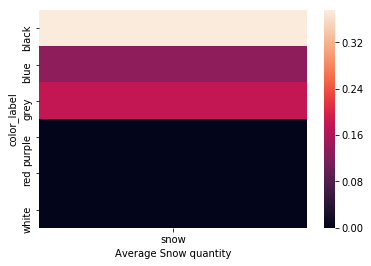

In [60]:
## VISUALIZATION BETWEEN SNOW AND COLOR-LABEL 

snow_color_df = joined_data[['color_label','snow']]
snow_color_df = snow_color_df.groupby(snow_color_df['color_label']).agg(np.mean)
snow_color_df

x = sns.heatmap(snow_color_df)
x.set_xlabel('Average Snow quantity')
plt.savefig('plots/snowvsweather.jpg')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11561 entries, 0 to 11560
Data columns (total 53 columns):
Date/Time               11561 non-null datetime64[ns]
Year                    11561 non-null int64
Month                   11561 non-null int64
Day                     11561 non-null int64
Time                    11561 non-null object
Data Quality            11561 non-null object
Temp (°C)               11561 non-null float64
Dew Point Temp (°C)     11561 non-null float64
Rel Hum (%)             11561 non-null float64
Wind Dir (10s deg)      11552 non-null float64
Wind Spd (km/h)         11561 non-null float64
Visibility (km)         11561 non-null float64
Stn Press (kPa)         11561 non-null float64
Wind Chill              301 non-null float64
Weather                 11561 non-null object
timestamp               11561 non-null object
color                   11561 non-null object
is_clear                11561 non-null int64
is_snow                 11561 non-null int64
is_fog  

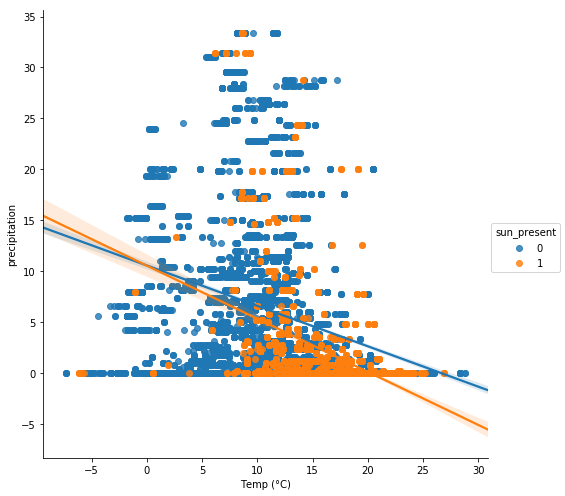

In [18]:
rain_agg = joined_data[['precipitation','color_label']]
rain_agg = rain_agg.groupby(rain_agg['color_label']).agg(np.mean)
rain_agg = rain_agg.reset_index(level=0)

ax = sns.lmplot(x='Temp (°C)',y='precipitation',hue='sun_present',data=joined_data,size=7)
ax.set_titles('asdf')
ax.set_ylabels('precipitation')
joined_data.info()

In [19]:
## NOW ADDING CRIME DATA TO THE WEATHER + IMAGE DATASET AND SEE ANY CRUCIAL INFORMATION WE GET OR NOT 
## SCRAP UNRELEVANT DATA

f1 = ['Temp (°C)','Dew Point Temp (°C)','Rel Hum (%)','Wind Dir (10s deg)','Wind Spd (km/h)','Visibility (km)','color_label','sun_present','avg_pressure_station','snow','sunlight','rain','new_weather']
#f2 = ['color_label','sun_present','new_weather']
f2 = ['Temp (°C)','Dew Point Temp (°C)','Rel Hum (%)','Wind Dir (10s deg)','Wind Spd (km/h)','Visibility (km)','color_label','sun_present','avg_pressure_station','snow','sunlight','rain','TYPE','new_weather']

crime_joined_data = joined_data[f2]
joined_data = joined_data[f1]
joined_data = joined_data.dropna(axis=0,how='any')

labeled_data_X = joined_data.loc[:,joined_data.columns!='new_weather']
labeled_data_X = pd.get_dummies(labeled_data_X)
#print(labeled_data_X.columns) 
labeled_data_y = joined_data['new_weather']
g = joined_data['new_weather'].values
#print(labeled_data_y[0:5])

## thing noticed that proposing color labels and sun_present is not contributing significantly to our results. That means the origin algorithm in matlab can be further improved. 

In [61]:
## MODEL EVALUATION WITHOUT ANY SCALING OR TRANSFORMATIONS (other than done manually above)
## first evaluating minimum manual set parameters 

from sklearn.naive_bayes import GaussianNB,BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.model_selection import cross_val_score,KFold,ShuffleSplit
from sklearn.feature_selection import SelectKBest, chi2,f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Imputer
from sklearn.decomposition import PCA
import graphviz
from sklearn.pipeline import make_pipeline


pca_n_features = 2

scaling = make_pipeline(StandardScaler())
fe = make_pipeline(PCA(7))

preprocessing = make_pipeline(scaling,Imputer(missing_values="NaN",strategy="mean"))

bayes_model = make_pipeline(preprocessing,GaussianNB())
bayes_model.__name__ = 'Naive Bayes'

bernolli_model = make_pipeline(preprocessing, BernoulliNB())
bernolli_model.__name__ = 'Bernoulli'

k = 6
knn_model = make_pipeline(preprocessing,KNeighborsClassifier(n_neighbors=k))
knn_model.__name__ = 'KNeighbors'

svm_model = make_pipeline(preprocessing,SVC(kernel='linear',decision_function_shape='ovr'))
svm_model.__name__ = 'SVM'

tree_model = make_pipeline(preprocessing,DecisionTreeClassifier(random_state=0))
tree_model.__name__ = 'Decision Tree'

logreg_model = make_pipeline(preprocessing,LogisticRegression())
logreg_model.__name__ = 'Log Regression'

MODEL = [bayes_model,knn_model,svm_model,tree_model,logreg_model,bernolli_model]




In [62]:
def cross_validation_evaluation(labeled_data_X,labeled_data_y) : 
        
    print('\nCROSSVALIDATION with folding------------------------------')
    kfold = KFold(n_splits=10)
    for m in MODEL : 
        score = cross_val_score(m,labeled_data_X.values,labeled_data_y,cv=kfold)
        print('{} : {}'.format(m.__name__,score.mean()))

    print('\nCROSSVALIDATION with Shuffling------------------------------')
    shuffle = ShuffleSplit(test_size=.75,train_size=.25,n_splits=50)
    for m in MODEL : 
        score = cross_val_score(m,labeled_data_X.values,labeled_data_y,cv=shuffle)
        print('{} : {}'.format(m.__name__,score.mean()))

    train_X,test_X,train_y,test_y = train_test_split(labeled_data_X,labeled_data_y)
    print('\nDIRECT MODEL EVALUATION ------------------------------')
    for m in MODEL : 
        m.fit(train_X,train_y)
        s = m.score(test_X,test_y)
        print('{} : {}'.format(m.__name__,s))
        
cross_validation_evaluation(labeled_data_X,labeled_data_y)


CROSSVALIDATION with folding------------------------------
Naive Bayes : 0.43594459648417294
KNeighbors : 0.6219429909855705
SVM : 0.7021624347094677
Decision Tree : 0.628163760857453
Log Regression : 0.7000601678252554
Bernoulli : 0.6934017230714448

CROSSVALIDATION with Shuffling------------------------------
Naive Bayes : 0.4228861646234676
KNeighbors : 0.7572025685931116
SVM : 0.7253847051955634
Decision Tree : 0.8906363105662581
Log Regression : 0.7213706946876823
Bernoulli : 0.7006514886164622

DIRECT MODEL EVALUATION ------------------------------
Naive Bayes : 0.4290718038528897
KNeighbors : 0.8651488616462347
SVM : 0.7411558669001751
Decision Tree : 0.9810858143607706
Log Regression : 0.7215411558669002
Bernoulli : 0.7015761821366024


In [22]:
train_X,test_X,train_y,test_y = train_test_split(labeled_data_X,labeled_data_y)
print('Direct Model Evaluation')
for m in MODEL : 
    m.fit(train_X,train_y)
    s = m.score(test_X,test_y)
    print('{} : {}'.format(m.__name__,s))

Direct Model Evaluation
Naive Bayes : 0.4238178633975482
KNeighbors : 0.8784588441330998
SVM : 0.7215411558669002
Decision Tree : 0.9817863397548161
Log Regression : 0.7208406304728546
Bernoulli : 0.703677758318739


In [32]:
## predicting missing weather values 

wiudata = udata.merge(filenames,on='timestamp')
ujoined_data = wiudata.merge(cdata,on='timestamp')
ujoined_data['date_only'] = ujoined_data.apply(date_only,axis=1)
ujoined_data = ujoined_data.merge(snow_data,on='date_only')

## BEST MODEL SO FAR WAS DECISION TREE (FROM MANUAL MODEL EVALUATION). so, let's predict

features = ['Temp (°C)','Dew Point Temp (°C)','Rel Hum (%)','Wind Dir (10s deg)','Wind Spd (km/h)','Visibility (km)','color_label','sun_present','avg_pressure_station','snow','sunlight','rain']

ujoined_data = ujoined_data[features]
ujoined_data = ujoined_data.dropna(axis=0,how='any')

predict_data = ujoined_data
predict_data = pd.get_dummies(labeled_data_X)


#tree_model.fit(labeled_data_X,labeled_data_y)
#tree_model.predict(predict_data)
#predict_data.info()
print('joined_data')

(11419, 13)

In [63]:
## NOW COORELATING THE CRIME 



## remove the new_weather because we don't know it for unlabelled.
crime_joined_data = crime_joined_data.loc[:,crime_joined_data.columns!='new_weather']

crime_joined_data = crime_joined_data.dropna(axis=0,how='any')


crime_labelled_data_X = crime_joined_data.loc[:,crime_joined_data.columns!='TYPE']
crime_labelled_data_y = crime_joined_data['TYPE']
crime_labelled_data_X = pd.get_dummies(crime_labelled_data_X)


print(crime_labelled_data_y.shape)
print(crime_labelled_data_X.shape)


## evaluation
##cross_validation_evaluation(crime_labelled_data_X,crime_labelled_data_y)


(11419,)
(11419, 17)

CROSSVALIDATION with folding------------------------------
Naive Bayes : 0.018915260064680414
KNeighbors : 0.23592257076242767
SVM : 0.3288407256362517
Decision Tree : 0.21455631601001368
Log Regression : 0.32297213707826883
Bernoulli : 0.28216584217304086

CROSSVALIDATION with Shuffling------------------------------
Naive Bayes : 0.08495738470519555
KNeighbors : 0.24471453590192646
SVM : 0.32851838879159373
Decision Tree : 0.20632807939287798
Log Regression : 0.3239299474605955
Bernoulli : 0.2867694103911267

DIRECT MODEL EVALUATION ------------------------------
Naive Bayes : 0.025569176882661998
KNeighbors : 0.24168126094570927
SVM : 0.32609457092819616
Decision Tree : 0.22206654991243432
Log Regression : 0.3215411558669002
Bernoulli : 0.29176882661996495
